# Spotify Song Analysis and Visualization

## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

We start by importing the necessary libraries.

pandas is used for data manipulation and analysis.
seaborn and matplotlib.pyplot are used for data visualization.
sklearn modules provide functions for data preprocessing, model training, and evaluation.

## Loading the Data

In [2]:
spotify_data = pd.read_csv("/kaggle/input/top-spotify-songs-in-73-countries-daily-updated/universal_top_spotify_songs.csv")
print(spotify_data.head())

               spotify_id                name                artists  \
0  2plbrEY59IikOBgBGLjaoe    Die With A Smile  Lady Gaga, Bruno Mars   
1  5vNRhkKd0yEAg8suGBpjeY                APT.       ROSÉ, Bruno Mars   
2  6dOtVTDdiauQNBQEDOtlAB  BIRDS OF A FEATHER          Billie Eilish   
3  7tI8dRuH2Yc6RuoTjxo4dU                 Who                  Jimin   
4  7ne4VBA60CxGM75vw0EYad      That’s So True          Gracie Abrams   

   daily_rank  daily_movement  weekly_movement country snapshot_date  \
0           1               0                1     NaN    2024-11-12   
1           2               0               -1     NaN    2024-11-12   
2           3               0                0     NaN    2024-11-12   
3           4               0                0     NaN    2024-11-12   
4           5               1                4     NaN    2024-11-12   

   popularity  is_explicit  ...  key loudness mode  speechiness  acousticness  \
0          99        False  ...    6   -7.777    0   

The dataset is loaded into a DataFrame called spotify_data. The .head() function shows the first few rows, which helps us understand the structure and content of the data.

## Checking Missing Values

In [3]:
print(spotify_data.isnull().sum())

spotify_id                0
name                     29
artists                  28
daily_rank                0
daily_movement            0
weekly_movement           0
country               19257
snapshot_date             0
popularity                0
is_explicit               0
duration_ms               0
album_name              670
album_release_date      507
danceability              0
energy                    0
key                       0
loudness                  0
mode                      0
speechiness               0
acousticness              0
instrumentalness          0
liveness                  0
valence                   0
tempo                     0
time_signature            0
dtype: int64


Counting missing values in each column helps us understand data quality and identify columns that need cleaning.

## Data Cleaning and Preprocessing

## Removing Duplicate Rows

In [4]:
spotify_data = spotify_data.drop_duplicates()

Duplicate rows are removed to ensure each entry in the dataset is unique, which is essential for accurate analysis.

## Date Conversion

In [5]:
spotify_data['snapshot_date'] = pd.to_datetime(spotify_data['snapshot_date'], errors='coerce')
spotify_data['album_release_date'] = pd.to_datetime(spotify_data['album_release_date'], errors='coerce')

 We convert snapshot_date and album_release_date columns to datetime format. This allows for easier manipulation and analysis of time-based data.

## Handling Missing Essential Data

In [6]:
spotify_data = spotify_data.dropna(subset=['name', 'artists', 'country'])

Rows with missing values in critical columns name, artists, and country are removed, as these fields are essential for analysis.

## Filling Missing Album Names

In [7]:
spotify_data['album_name'] = spotify_data['album_name'].fillna("Unknown Album")

Missing values in the album_name column are filled with "Unknown Album" to keep data consistent and avoid null values in further analysis.

## Filling Missing Album Release Dates

In [8]:
avg_release_date = spotify_data.groupby('artists')['album_release_date'].transform(lambda x: x.fillna(x.mean()))
spotify_data['album_release_date'] = spotify_data['album_release_date'].fillna(avg_release_date)

To handle missing values in album_release_date, we fill them with the average release date per artist. This approach ensures that each artist's missing album dates are approximated based on other data for that artist.

## Post-Cleaning Missing Values Check

In [9]:
print("Missing values setelah pembersihan:")
print(spotify_data.isnull().sum())

Missing values setelah pembersihan:
spotify_id            0
name                  0
artists               0
daily_rank            0
daily_movement        0
weekly_movement       0
country               0
snapshot_date         0
popularity            0
is_explicit           0
duration_ms           0
album_name            0
album_release_date    0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
dtype: int64


After cleaning, we recheck for missing values to verify that the data is prepared for analysis.

## Verifying Data Types

In [10]:
print(spotify_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1395444 entries, 50 to 1414729
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   spotify_id          1395444 non-null  object        
 1   name                1395444 non-null  object        
 2   artists             1395444 non-null  object        
 3   daily_rank          1395444 non-null  int64         
 4   daily_movement      1395444 non-null  int64         
 5   weekly_movement     1395444 non-null  int64         
 6   country             1395444 non-null  object        
 7   snapshot_date       1395444 non-null  datetime64[ns]
 8   popularity          1395444 non-null  int64         
 9   is_explicit         1395444 non-null  bool          
 10  duration_ms         1395444 non-null  int64         
 11  album_name          1395444 non-null  object        
 12  album_release_date  1395444 non-null  datetime64[ns]
 13  danceability    

We check data types of each column to ensure they are correct, especially after transformations. This helps avoid potential errors in further analysis steps.

## Popularity Analysis and Visualization

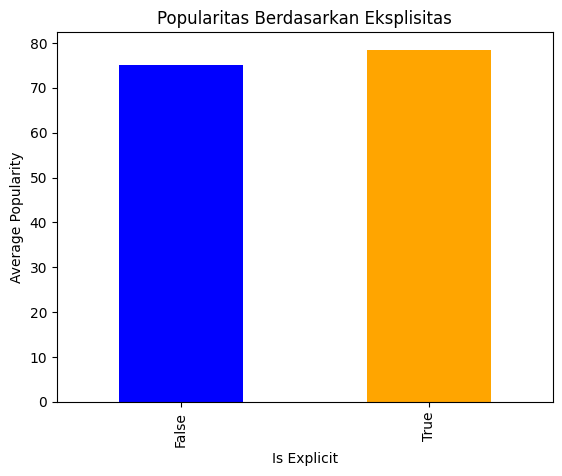

In [11]:
# Calculating Average Popularity Based on Explicitness
explicitness_popularity = spotify_data.groupby('is_explicit')['popularity'].mean()

# Visualizing Popularity Based on Explicitness
explicitness_popularity.plot(kind='bar', color=['blue', 'orange'])
plt.title("Popularitas Berdasarkan Eksplisitas")
plt.xlabel("Is Explicit")
plt.ylabel("Average Popularity")
plt.show()

This plot shows the comparison of average popularity between songs labeled as explicit and non-explicit. It appears that the average popularity of explicit songs (True) is slightly higher than that of non-explicit songs (False). However, the difference is not very significant, indicating that whether a song is labeled explicit or not does not have a substantial impact on its popularity. Thus, both explicit and non-explicit songs can reach similar levels of popularity, suggesting that audiences do not particularly mind or are not influenced by the explicit label when determining a song’s popularity.

## Feature Correlation Analysis

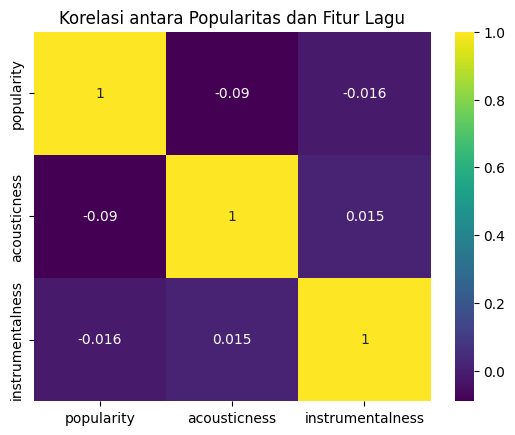

In [12]:
# Calculating Correlation Between Popularity and Acoustic Features
feature_correlation = spotify_data[['popularity', 'acousticness', 'instrumentalness']].corr()

# Visualizing Feature Correlation with Heatmap
sns.heatmap(feature_correlation, annot=True, cmap='viridis')
plt.title("Korelasi antara Popularitas dan Fitur Lagu")
plt.show()

This plot shows the correlation matrix between song popularity and features such as acousticness and instrumentalness. The correlation results indicate that there is no significant relationship between popularity and these two features, as shown by the very low correlation values: -0.09 between popularity and acousticness, and -0.016 between popularity and instrumentalness. This suggests that the acoustic and instrumental features of a song do not significantly affect its popularity. Additionally, the relationship between acousticness and instrumentalness is also very weak, with a correlation value of 0.015. These low overall correlations suggest that the three variables tend to be independent of each other, and song popularity is not noticeably influenced by the acousticness or instrumentalness features.

## Analysis of Top 10 Ranked Songs

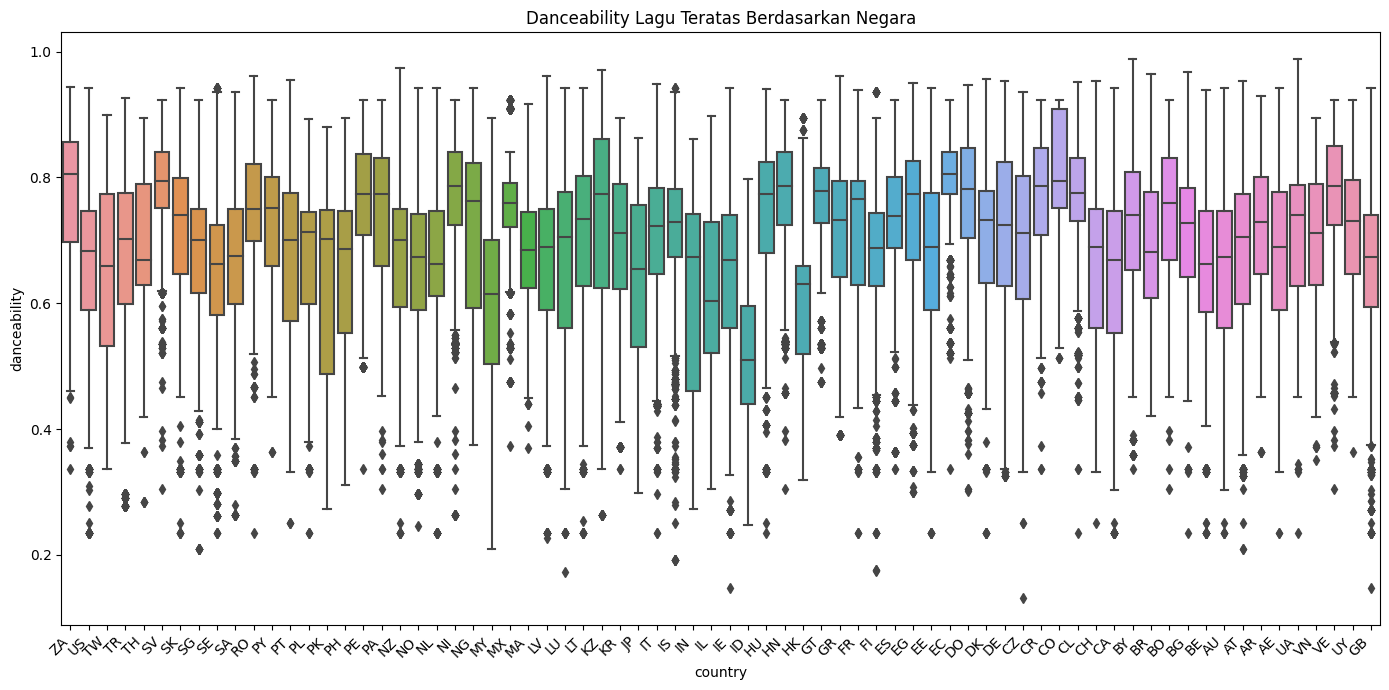

In [13]:
# Filtering Top 10 Ranked Songs
top_songs = spotify_data[spotify_data['daily_rank'] <= 10]

# Removing Rows with Missing Values in Key Columns
top_songs = top_songs.dropna(subset=['country', 'danceability'])

# Filtering Countries with Sufficient Data
country_counts = top_songs['country'].value_counts()
top_countries = country_counts[country_counts >= 10].index
top_songs_filtered = top_songs[top_songs['country'].isin(top_countries)]

# Visualizing Danceability Distribution of Top Songs by Country
plt.figure(figsize=(14, 7))
sns.boxplot(data=top_songs_filtered, x='country', y='danceability')
plt.title("Danceability Lagu Teratas Berdasarkan Negara")
plt.xticks(rotation=45, ha='right')  # Memutar label negara dan menyelaraskan ke kanan
plt.tight_layout()
plt.show()

This plot shows the variation in danceability of popular songs across different countries, with diverse distributions in each country. Some countries have consistently high danceability for their popular songs, while others show wider variation or tend to have lower values. This indicates that preferences for danceability may be influenced by the local culture or music trends in each country. Additionally, the presence of many outliers in some countries suggests that there are songs with danceability characteristics significantly different from the majority of other popular songs in that country. Overall, this distribution reflects differences in musical tastes and preferences around the world, especially regarding the danceability of favored songs.